In [4]:
!date

Tue Jun 20 12:54:55 EDT 2023


In [3]:
pwd

'/mmfs1/data/aglinska/BC-ABCD-ADHD'

In [2]:
import ants
import numpy as np
import pandas as pd
import os

In [15]:
import numpy as np
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0


In [103]:
brain_size = (64,64,64)

In [142]:
temp = ants.image_read('./Misc/Atlas_brain_2mm.nii')
temp = ants.resample_image(image=temp,resample_params=brain_size,use_voxels=True,interp_type=1)
temp = temp.iMath_normalize()

In [143]:
temp.max()

1.0

In [144]:
# brain_size = temp.shape
# print(brain_size)

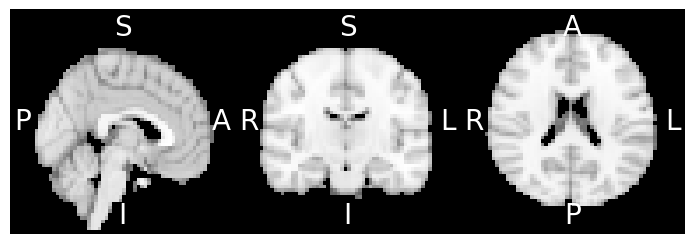

In [145]:
temp.plot_ortho(flat=True,xyz_lines=False)

In [245]:
coords = (32,32,50)

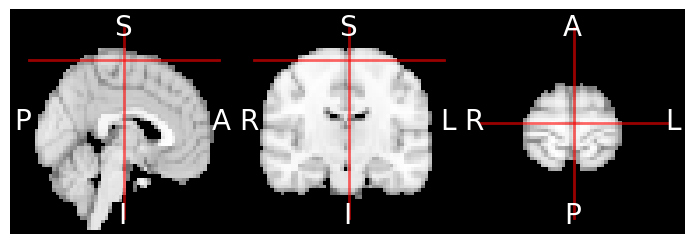

In [246]:
temp.plot_ortho(flat=True,xyz=coords)

In [247]:
sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=2, position=coords)*1.0)
sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=8, position=coords)*1.0)
#.plot_ortho(flat=True,xyz=[32,32,32])

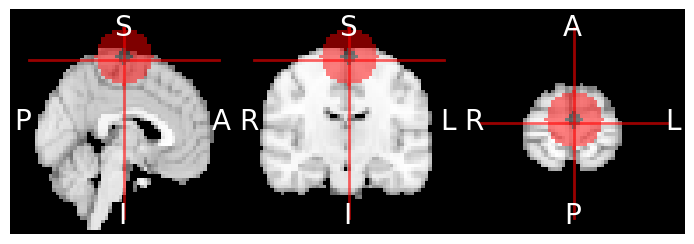

In [248]:
temp.plot_ortho(sphere_small*3+sphere_big*7,overlay_cmap='flag',xyz=coords,flat=True,overlay_alpha=.5)

In [249]:
#mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big,type_of_transform = 'SyN' )
mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big,type_of_transform = 'SyNOnly' )

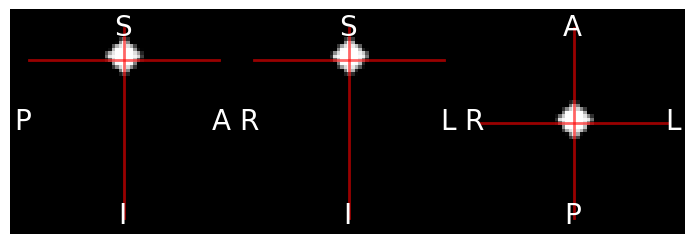

In [251]:
mytx['warpedmovout'].plot_ortho(flat=True,xyz=coords)

/scratch/aglinska/tmp0w4779k71Warp.nii.gz


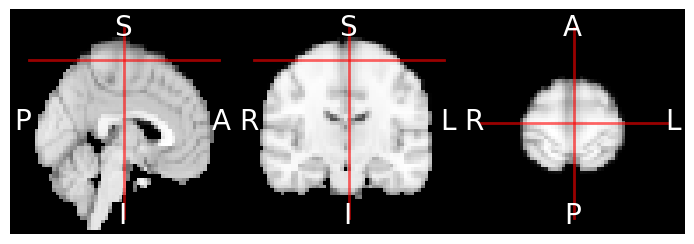

In [255]:
warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0])
print(mytx['fwdtransforms'][0])
warpedBrain.plot_ortho(flat=True,xyz=coords)

In [ ]:
temp.plot_ortho_double(warpedBrain,xyz=coords)

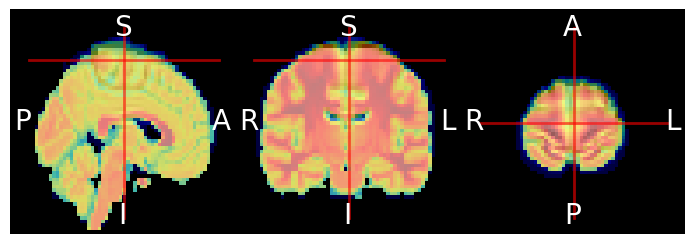

In [256]:
temp.plot_ortho(warpedBrain,flat=True,overlay_alpha=.5,xyz=coords)

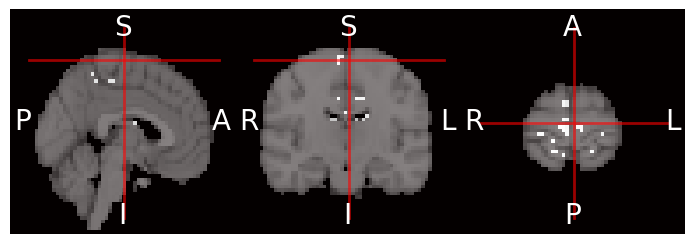

In [275]:
temp.plot_ortho((temp-warpedBrain)>np.sort((temp-warpedBrain).numpy().flatten())[-250],flat=True,overlay_alpha=.5,overlay_cmap='hot',xyz=coords)

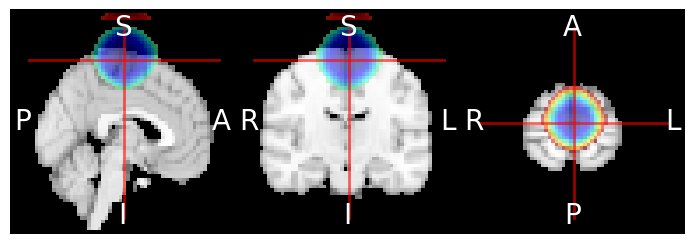

In [258]:
J = ants.create_jacobian_determinant_image(domain_image=temp,tx=mytx['fwdtransforms'][0])
J = J-1
J[abs(J.numpy())<.25]=0
temp.plot_ortho(J,flat=True,overlay_alpha=.5,xyz=coords)

In [336]:
def do_selective_tx(temp,coords = (32,32,50),sz1=10,sz2=2):

    sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=sz1, position=coords)*1.0)
    sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=sz2, position=coords)*1.0)

    temp.plot_ortho(sphere_small*3+sphere_big*7,overlay_cmap='flag',xyz=coords,flat=True,overlay_alpha=.5,title='Deformation Targets')

    mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big+sphere_small,type_of_transform = 'SyNOnly' )
    warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0])
    #print(mytx['fwdtransforms'][0])
    #warpedBrain.plot_ortho(flat=True,xyz=coords)

    #mytx['warpedmovout'].plot_ortho(flat=True,xyz=coords)
    temp.plot_ortho_double(warpedBrain,xyz=coords,title='Before and After',title_dy=.22)
    #temp.plot_ortho((temp-warpedBrain)>np.sort((temp-warpedBrain).numpy().flatten())[-250],flat=True,overlay_alpha=.5,overlay_cmap='hot',xyz=coords)
    #temp.plot_ortho(warpedBrain-temp,flat=True,overlay_alpha=.5,overlay_cmap='bwr',xyz=coords)
    (warpedBrain-temp).plot_ortho(flat=True,cmap='bwr',xyz=coords,title='Difference Map')
    J = ants.create_jacobian_determinant_image(domain_image=temp,tx=mytx['fwdtransforms'][0])
    J = J-1
    #J[abs(J.numpy())<.25]=0
    temp.plot_ortho(J,flat=True,overlay_alpha=.5,xyz=coords,title='Jacobian Map')
    
    return warpedBrain

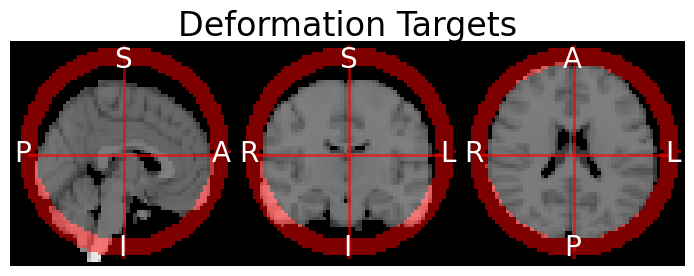

In [ ]:
#do_selective_tx(temp,coords = (32,32,32),sz1=30,sz2=25) # Global compress realistic
do_selective_tx(temp,coords = (32,32,32),sz1=25,sz2=30) # Global compress realistic
#do_selective_tx(temp,coords = (32,32,32),sz1=2,sz2=8); # Expand Ventricles
#do_selective_tx(temp,coords = (32,50,22),sz1=4,sz2=1); # Shrink OFC